In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scanpy as sc
from scipy.stats import median_abs_deviation
import seaborn as sns

In [2]:
adatas = []
perSampleDir = Path('../data/raw/cellRangerOuts/BRI-2941/per_sample_outs/')
for experimentDir in perSampleDir.iterdir():
    adataPath = experimentDir / 'count' / 'sample_filtered_feature_bc_matrix.h5'
    adataSample = sc.read_10x_h5(adataPath)
    adataSample.var_names_make_unique()
    adataSample.obs['sample'] = experimentDir.stem
    adatas.append(adataSample)
adata = anndata.concat(adatas)

/data/trm-sc-analysis/.pixi/envs/default/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/trm-sc-analysis/.pixi/envs/default/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/trm-sc-analysis/.pixi/envs/default/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/trm-sc-analysis/.pixi/envs/default/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/trm-sc-analysis/.pixi/envs/default/lib/python3.12/site-pac

In [3]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.upper().str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.upper().str.contains("^HB[^(P)]")

In [4]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

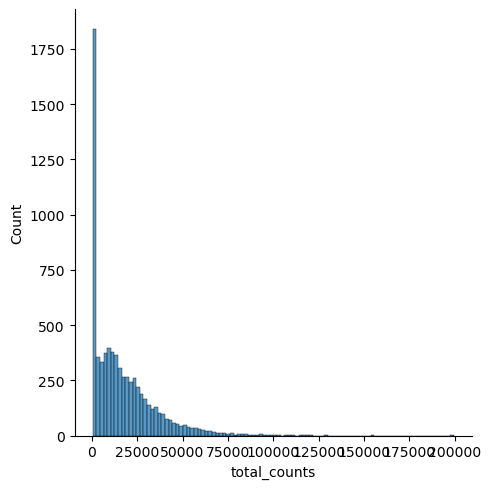

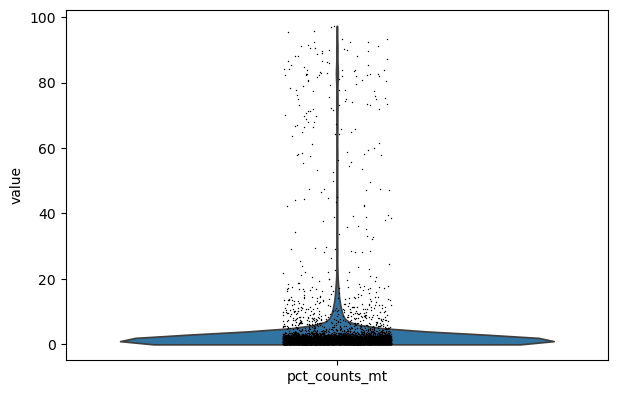

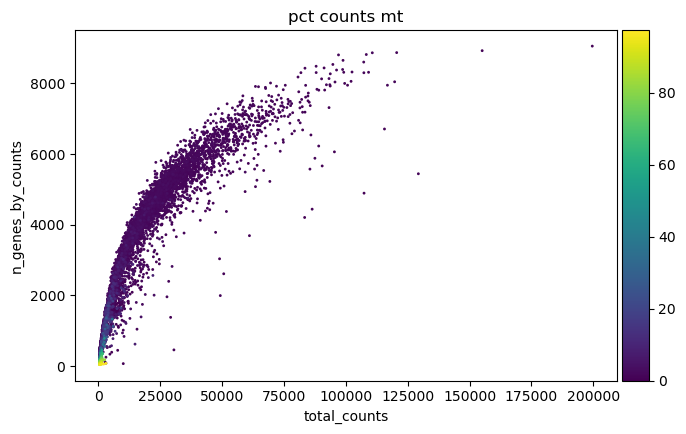

In [5]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [6]:
# The data is heavily skewed, so I'm going to remove the really low count cells
thresh = 2500
adata = adata[adata.obs['total_counts']>thresh].copy()

In [7]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [8]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    4945
True      444
Name: count, dtype: int64

In [9]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 8
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    4858
True      531
Name: count, dtype: int64

In [10]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
adata.layers["counts"] = adata.X

Total number of cells: 5389
Number of cells after filtering of low quality cells: 4583


In [11]:
import anndata2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

data_mat = adata.X.T
# samples = adata.obs["sample"]
importr("SingleCellExperiment")
importr("scDblFinder")
importr("BiocParallel")

detect_doublets = ro.functions.wrap_r_function(
    ro.r(
        """
function(data_mat){
print("data loaded, proceeding with doublet detection")
# bp <- MulticoreParam(cores, RNGseed=9)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    )
)
return(
    list(
        score=sce$scDblFinder.score,
        class=sce$scDblFinder.class
    )
)
}
"""
    ),
    "detect_doublets",
)
with (
    ro.default_converter + ro.pandas2ri.converter + anndata2ri.converter
).context():
    outs = detect_doublets(data_mat)

adata.obs["scDblFinder_score"] = outs["score"]
adata.obs["scDblFinder_class"] = outs["class"]

[1] "data loaded, proceeding with doublet detection"


R[write to console]: Creating ~3667 artificial doublets...

R[write to console]: Dimensional reduction

R[write to console]: Evaluating kNN...

R[write to console]: Training model...

R[write to console]: iter=0, 557 cells excluded from training.

R[write to console]: iter=1, 557 cells excluded from training.

R[write to console]: iter=2, 557 cells excluded from training.

R[write to console]: Threshold found:0.358

R[write to console]: 355 (7.7%) doublets called



In [12]:
adata.write_h5ad('../data/interim/BRI-2941/BRI-2941_qc.h5ad')

In [13]:
adata = sc.read_h5ad('../data/interim/BRI-2941/BRI-2941_qc.h5ad')

In [14]:
# Shifted logarithm normalization
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

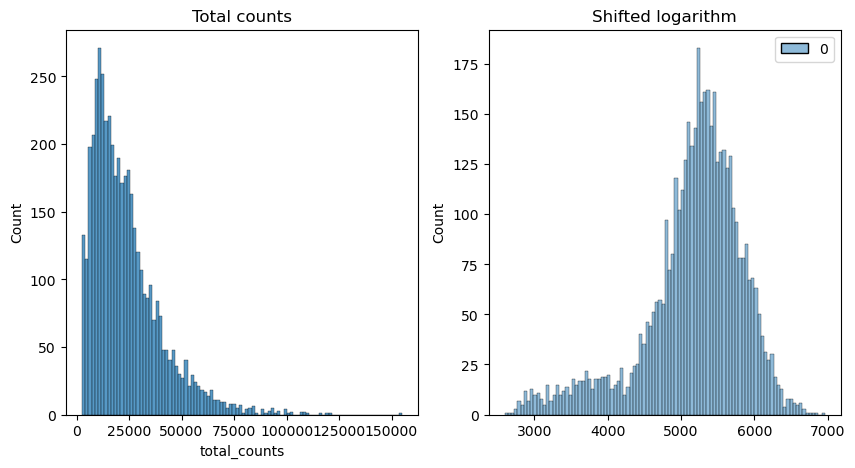

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [16]:
importr('scry')

featureSelection = ro.functions.wrap_r_function(
    ro.r(
        """
function(adata){
print("anndata loaded")
print(adata)
sce = devianceFeatureSelection(adata, assay="X")
return(rowData(sce)$binomial_deviance)
}
"""
    ),
    "featureSelection",
)
with (
    ro.default_converter + ro.pandas2ri.converter + anndata2ri.converter
).context():
    binomial_deviance = featureSelection(adata).T

[1] "anndata loaded"
class: SingleCellExperiment 
dim: 31053 4583 
metadata(0):
assays(3): X counts log1p_norm
rownames(31053): Xkr4 Gm1992 ... Vmn2r122 CAAA01147332.1
rowData names(9): mt ribo ... total_counts log1p_total_counts
colnames(4583): AAACCATTCACCATTC-1 AAACCATTCGGCTCTC-1 ...
  GTTGGTTCAAGTACAG-1 GTTGGTTCACACAACT-1
colData names(19): sample n_genes_by_counts ... scDblFinder_score
  scDblFinder_class
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [17]:
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance

In [18]:
sc.pp.highly_variable_genes(adata, layer="log1p_norm")

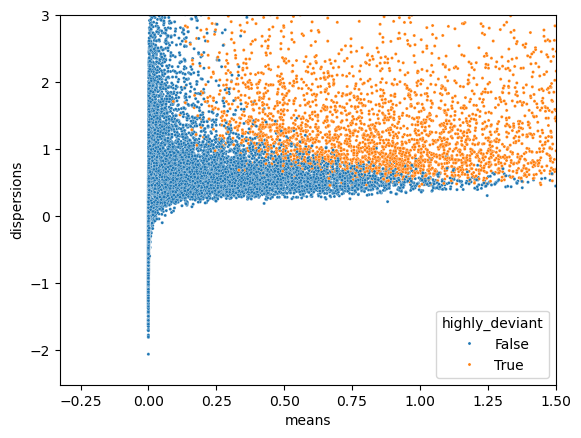

In [19]:
ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

In [20]:
adata.write_h5ad('../data/interim/BRI-2941/BRI-2941_featureSelection.h5ad')

In [21]:
adata = sc.read_h5ad('../data/interim/BRI-2941/BRI-2941_featureSelection.h5ad')

In [22]:
adata.X = adata.layers["log1p_norm"]

/data/trm-sc-analysis/.pixi/envs/default/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:226: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


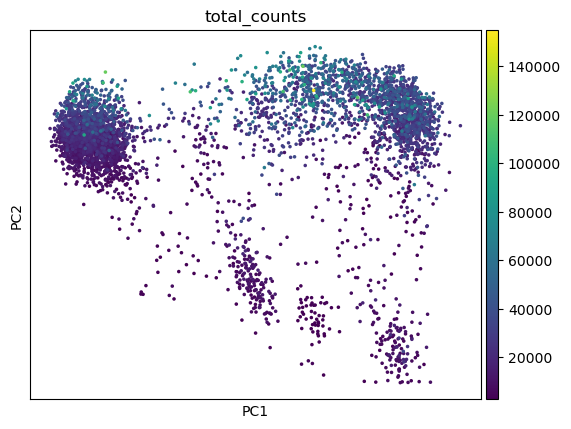

In [23]:
adata.var["highly_variable"] = adata.var["highly_deviant"]
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pl.pca_scatter(adata, color="total_counts")

In [24]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

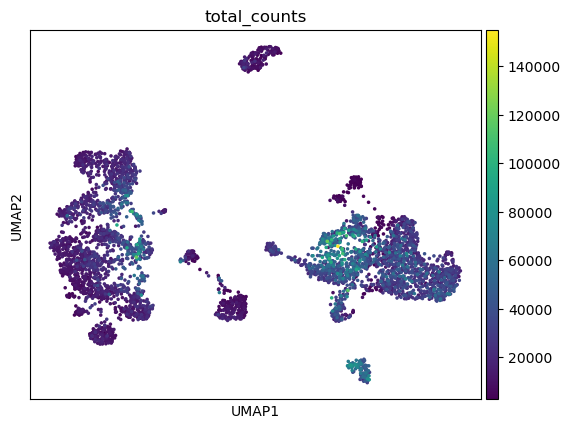

In [25]:
sc.pl.umap(adata, color="total_counts")

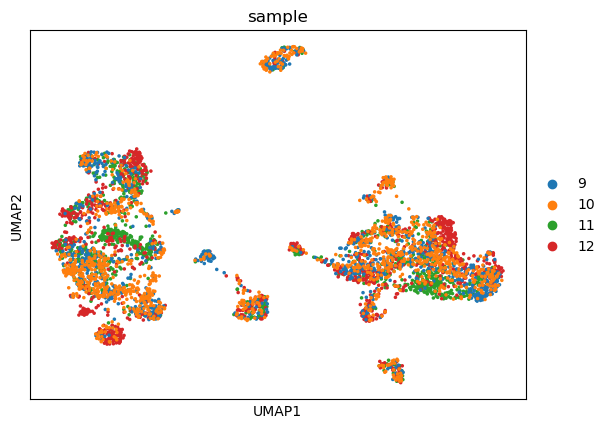

In [26]:
sc.pl.umap(adata, color="sample")

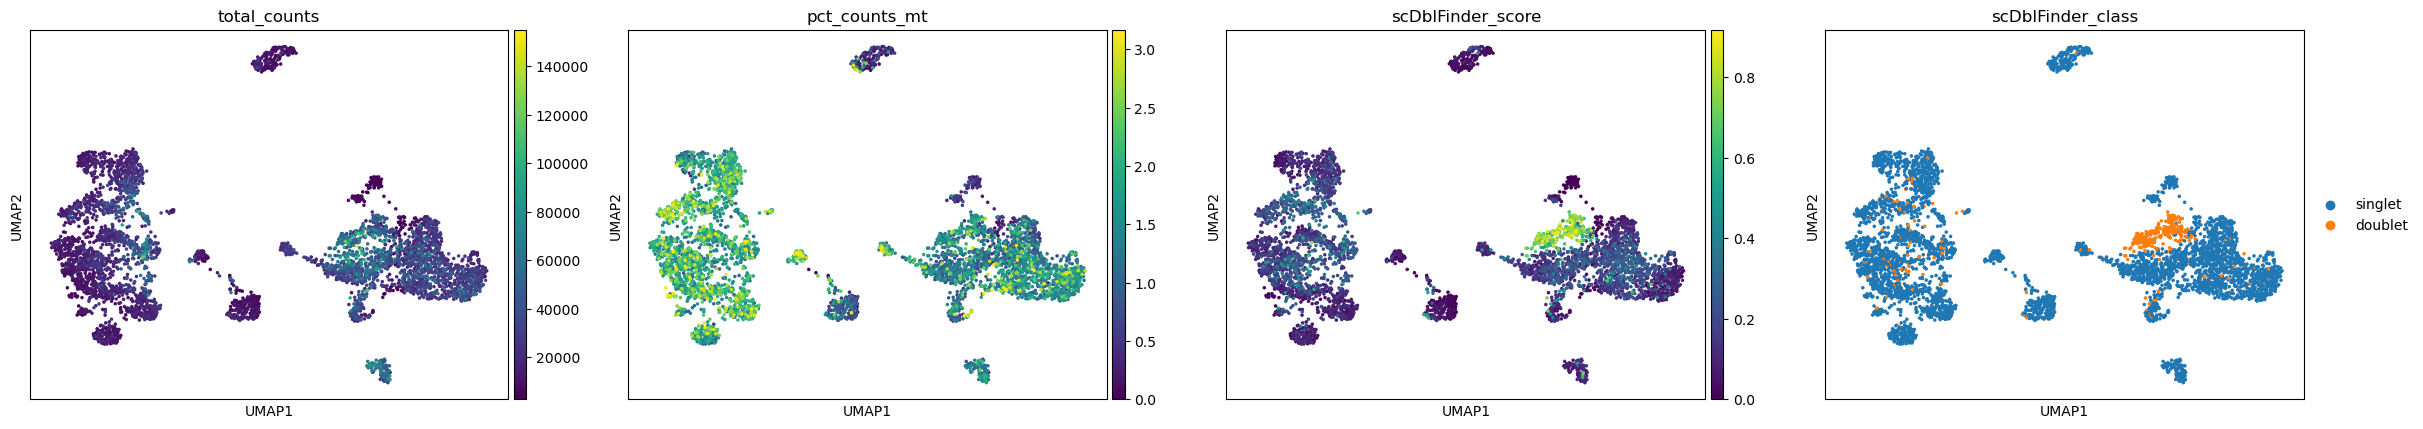

In [27]:
sc.pl.umap(
    adata,
    color=["total_counts", "pct_counts_mt", "scDblFinder_score", "scDblFinder_class"],
)

In [28]:
adata.write_h5ad('../data/interim/BRI-2941/BRI-2941_reduced.h5ad')

In [29]:
adata = sc.read_h5ad('../data/interim/BRI-2941/BRI-2941_reduced.h5ad')

In [30]:
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)

In [31]:
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

/tmp/ipykernel_36224/3088376165.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)


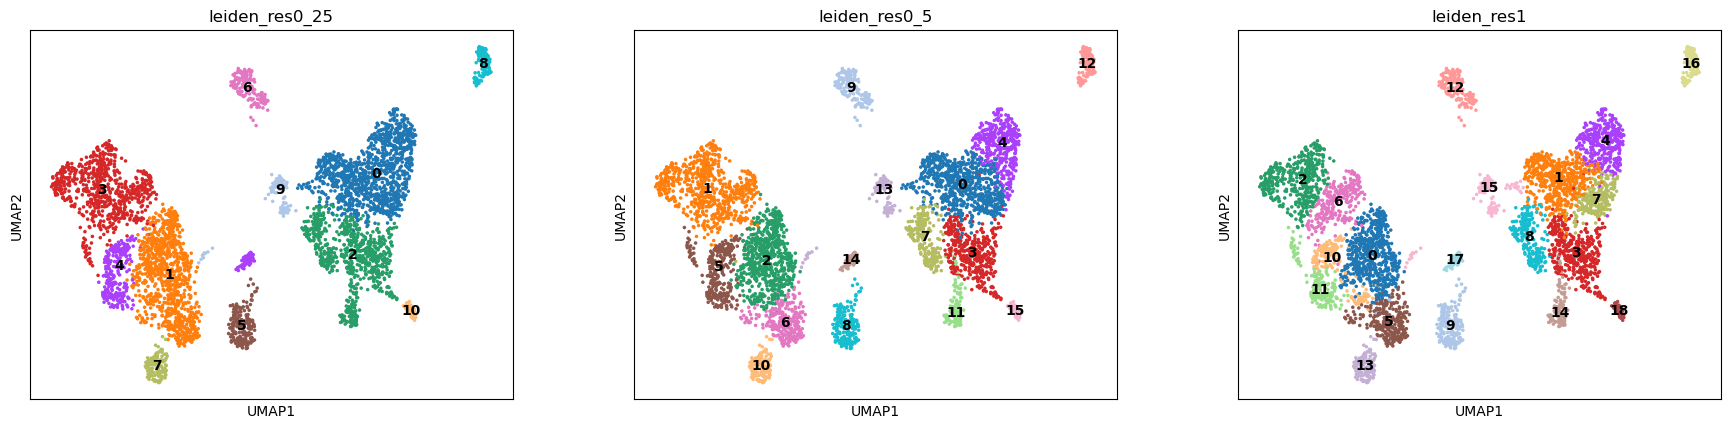

In [32]:
sc.pl.umap(
    adata,
    color=["leiden_res0_25", "leiden_res0_5", "leiden_res1"],
    legend_loc="on data",
)

In [ ]:
# %%